In [75]:

import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:

import random
import torch
import torch.nn as nn
import math
import torch
import numpy as np
import random
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from google.colab import drive

from torch.utils.data import TensorDataset, DataLoader


In [3]:
device

device(type='cpu')

### Paper Immplementation

Training Data Shape: torch.Size([1000, 200, 1])
Validation Data Shape torch.Size([200, 200, 1])


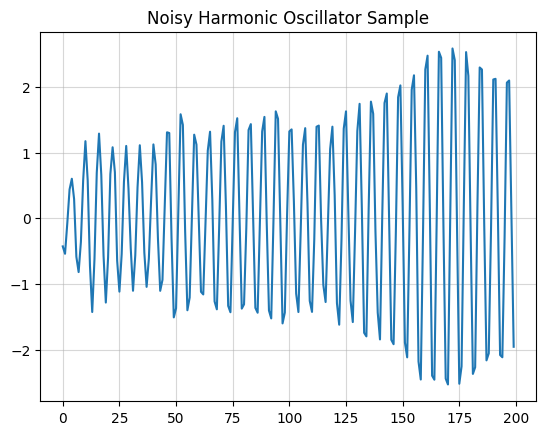

In [324]:

#Genearte noisy harmonic generator
def generate_harmonic_oscillator_data(num_samples=1000, sequence_length=200,
                                      k_range=(0.5, 2.0),
                                      noise_level=0.05, mass=10, random = True):
    """
    Generate noisy harmonic oscillator sequences.
    Returns: shape (num_samples, sequence_length, 1)
    """
    X = []
    #np.random.seed(100)

    for _ in range(num_samples):
        # Random spring constant and angular frequency
        #k = np.random.uniform(*k_range)
        k = 1 #we use mass to control the frequency
        if random:
          mass = np.random.randint(1,5)

        omega = np.sqrt(k / mass)

        # Initial conditions
        pos = np.zeros(sequence_length)
        vel = np.zeros(sequence_length)
        pos[0] = np.random.uniform(-1, 1)
        vel[0] = np.random.uniform(-1, 1)

        dt = 1.0
        for t in range(1, sequence_length):
            acc = - (k / mass) * pos[t - 1]

            #euler integration
            vel[t] = vel[t - 1] + dt * acc
            pos[t] = pos[t - 1] + dt * vel[t]

            # Add noise to position
            pos[t] += np.random.normal(0, noise_level)

        X.append(pos)

    X = np.array(X).reshape(num_samples, sequence_length, 1)
    #return X
    return torch.from_numpy(X).to(dtype=torch.float32)

# Generate data
X_train = generate_harmonic_oscillator_data(num_samples=1000, noise_level=0.1)
X_val = generate_harmonic_oscillator_data(num_samples=200)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape", X_val.shape)

# Plot a sample
plt.plot(X_train[1])
plt.title("Noisy Harmonic Oscillator Sample")
plt.grid(True, alpha=0.5)
plt.show()


In [325]:
train_dataset = generate_harmonic_oscillator_data(num_samples=5000, noise_level=0.1)


# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True) #shape 5000 x 200 x 1


In [326]:
def time_interval():

  prob = random.random()
  if prob < 0.8: #time interval [1,10] with prob 0.8
    t2 = random.randint(10,199) # max time interval is 10, so if t2 < 10 t1 will be negative if dt = 10
    t1 = random.randint(t2-10,t2-1)
  else: #time interval [1,120] with prob 0.2
    t2 = random.randint(120,199)
    t1 = random.randint(t2-120,t2-1)
  return t1, t2




In [327]:
## The belief state network/agrregator is an LSTM.
# we will use the lstm to generate belief states

class BeliefLSTM(nn.Module):
    def __init__(self, input_dim=1, belief_dim = 50):
        super(BeliefLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=belief_dim, batch_first=True)

    def forward(self, x):
        b, _= self.lstm(x)
        return b #(batch_size, sequence_length, belief_dim) = (1000, 200, 50)

        #preprocess


## DBlock

In [328]:
## From the paper we can see that DBlock can be MLP or RNN.
##For now we go with MLP
## This is a general block that  will pass any input  through a feedforward layer
# and provide a learned mean and variance that is used to model distributions

class Distribution_generator(nn.Module):
    def __init__(self, hidden_dim = 50, latent_dim = 8):
        """
        input_dim: dimensionality of the input context (e.g., b_t, z_t2, etc.)
        hidden_dim: dimensionality of the hidden layer normally set to 50
        output_dim: dimensionality of the output (i.e., z size) normally set to 8 as desscribed in the paper
        """
        super(Distribution_generator, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)  # W1 and B1
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # W2 and B2
        self.fc3 = nn.Linear(hidden_dim, 2 * latent_dim)  # W3 and B3 (outputs both mu and log sigma)

    def forward(self, x):
        """
        x: input (batch_size, input_dim)
        returns: mu, log_sigma of shape (batch_size, output_dim)
        """
        t1 = torch.tanh(self.fc1(x))        # W1x + B1 → tanh
        t2 = torch.sigmoid(self.fc2(x))     # W2x + B2 → sigmoid
        t = t1 * t2                         # element-wise product
        out = self.fc3(t)                   # W3(t) + B3 → outputs both mu and log sigma
        mu, log_sigma = torch.chunk(out, 2, dim=-1)
        return mu, log_sigma



In [329]:

def sample_gaussian(mu, logvar):
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  return mu + eps * std

def log_normal_pdf(x, mean, logvar, eps=1e-6):
    log_two_pi = torch.log(torch.tensor(2. * math.pi, device=x.device, dtype=x.dtype))
    return -0.5 * torch.sum(
        log_two_pi + logvar + ((x - mean) ** 2) / (torch.exp(logvar) + eps),
        dim=-1
    )

def kl_divergence(mu_q, logvar_q, mu_p, logvar_p):
    var_q = torch.exp(logvar_q) #getting back the variance from the log of variance
    var_p = torch.exp(logvar_p)
    return 0.5 * torch.sum(  #kl divergence of twogaussian distributions
        logvar_p - logvar_q +
        (var_q + (mu_q - mu_p)**2) / var_p - 1,
        dim=-1
    )



In [330]:
class Decoder(nn.Module):
    def __init__(self, z_size, hidden_size, x_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, x_size)

    def forward(self, z):
        t = torch.tanh(self.fc1(z))
        t = torch.tanh(self.fc2(t))
        logits = (self.fc3(t))
        return logits



In [389]:
class TDVAE_hierachical(nn.Module):
    def __init__(self, dblock, BeliefLSTM, belief_dim=50, latent_dim_1=8, latent_dim_2=8):
        super().__init__()
        self.latent_dim_1 = latent_dim_1
        self.latent_dim_2 = latent_dim_2


        self.beliefs = BeliefLSTM() #be careful with input dimension after preprocessing

        self.belief_layer2 = dblock(belief_dim, latent_dim_2)
        self.belief_layer1 = dblock(belief_dim + latent_dim_2, latent_dim_1)

        self.smoothing_layer2 = dblock(belief_dim + latent_dim_1 + latent_dim_2 + 1, latent_dim_1)
        self.smoothing_layer1 = dblock(belief_dim + latent_dim_2 + latent_dim_1 + latent_dim_2 +1, latent_dim_1)

        self.transition_layer2 = dblock(latent_dim_2 + latent_dim_1 + 1, latent_dim_1)
        self.transition_layer1 = dblock(latent_dim_2 + latent_dim_1 +latent_dim_2+ 1,latent_dim_1)


        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    def reset_loss_trackers(self):
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data, optimizer, device, beta):
        data = data.to(device)
        t1, t2= time_interval()





        #encoder
        bt = self.beliefs(data)
        mu2, logvar2 = self.belief_layer2(bt[:, t2, :])  # shape: [batch, latent_dim_2]
        zt2_layer2 = sample_gaussian(mu2, logvar2) #term 1

        mu1, logvar1 = self.belief_layer1(torch.cat([bt[:, t2, :], zt2_layer2], dim=-1))
        zt2_layer1 = sample_gaussian(mu1, logvar1) #term 2

        zt2 = torch.cat([zt2_layer1, zt2_layer2], dim =-1) #term3

        mut1_layer2, logvart1_layer2 = self.belief_layer2(bt[:, t1, :])  # shape: [batch, latent_dim_2] #term 4


        #smoothing
        dt = torch.full((data.size(0), 1), t2 - t1, dtype=bt.dtype, device=data.device)
        mu_smooth_layer2, logvar_smooth_layer2 = self.smoothing_layer2(torch.cat([bt[:, t1, :],zt2,dt], dim=-1))
        zt1_layer2_smooth = sample_gaussian(mu_smooth_layer2, logvar_smooth_layer2) #term5

        mut1_layer1, logvart1_layer1 = self.belief_layer1(torch.cat([bt[:, t1, :], zt1_layer2_smooth], dim=-1)) #term 6

        mu_smooth_layer1, logvar_smooth_layer1 = self.smoothing_layer1(torch.cat([bt[:, t1, :],zt2, zt1_layer2_smooth, dt], dim=-1))
        zt1_layer1_smooth = sample_gaussian(mu_smooth_layer1, logvar_smooth_layer1) #term7

        zt1 = torch.cat([zt1_layer1_smooth, zt1_layer2_smooth ], dim = -1) #term 8

        #transition
        mu_trans_layer2 , logvar_trans_layer2 = self.transition_layer2(torch.cat([zt1,dt], dim = -1)) #term 9

        mu_trans_layer1 , logvar_trans_layer1 = self.transition_layer1(torch.cat([zt1,zt2_layer2, dt], dim = -1)) #term 10

        #decoder
        #reconstruction = self.decoder(zt2_layer1[:,:1]) #IMP!! This is only for harmonic oscillator. dont do this for MNIST remember to change
        reconstruction = (zt2_layer1[:,:1]) #For harmonic the  decoder is super simple. we just pass the first component as output

        mse = torch.nn.MSELoss()
        Lx = mse(reconstruction, data[:,t2,:])
        # sum over input dimensions
        #the decoder is also different for MNIST

        #calculating losses now
        L1 = kl_divergence(mut1_layer2, logvart1_layer2 , mut1_layer2, logvart1_layer2) #for MNISTthis is different
        L2 = kl_divergence(mu_smooth_layer1, logvar_smooth_layer1, mut1_layer1, logvart1_layer1)
        L3 = log_normal_pdf(zt2_layer2, mu2, logvar2) - log_normal_pdf(zt2_layer2, mu_trans_layer2, logvar_trans_layer2)
        L4 = log_normal_pdf(zt2_layer1, mu1, logvar1) - log_normal_pdf(zt2_layer1, mu_trans_layer1, logvar_trans_layer1)


        #Lx = F.mse_loss(reconstruction, data[:,t2,:])#.sum(dim=-1)
        #Lx = -log_normal_pdf(data[:,t2,:],reconstruction,torch.tensor([0.0]))

        total_loss = (Lx + beta*(L1 + L2 + L3 + L4)).mean()
        reconstruction_loss = Lx.mean()
        kl_loss = (L1 + L2).mean()


        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # === Return metrics ===
        return {
            'loss': total_loss.item(),
            'reconstruction_loss': reconstruction_loss.item(),
            'kl_loss': kl_loss.item()
        }


























-------

In [390]:
def linear_beta_schedule(epoch, max_epochs, max_beta=1.0, min_beta=0.0):
    return min_beta + (max_beta - min_beta) * (epoch / max_epochs)


def cyclic_beta_schedule(step, warmup_steps, beta_max = 1.0):
    factor = step // warmup_steps + 1
    if factor % 2 == 1: # odd means ramping up
       current_max = warmup_steps * factor
       normalized_step = 1 - (current_max - step) / warmup_steps
       beta = beta_max * normalized_step
    else:
        beta = beta_max

    return beta


In [391]:

latent_dim = 8

In [392]:

vae = TDVAE_hierachical(Distribution_generator, BeliefLSTM, belief_dim=50, latent_dim_1=latent_dim, latent_dim_2=latent_dim)       # construct the model
vae.to(device)        # move to GPU/CPU
vae.train()           # <- do not remove or redefine this!
vae.reset_loss_trackers()

optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)

# scheduler = torch.optim.lr_scheduler.StepLR(  #TODO Added
#     optimizer,
#     step_size=10,   # every 10 epochs
#     gamma=0.1       # multiply LR by 0.1
# )

for batch in train_loader:
    x = batch.to(device)
    print(x.shape)
    metrics = vae.train_step(x, optimizer, device, beta = 1)
    print(metrics)

torch.Size([512, 200, 1])
{'loss': 4.108397960662842, 'reconstruction_loss': 2.7694547176361084, 'kl_loss': 0.3521993160247803}
torch.Size([512, 200, 1])
{'loss': 7.410314083099365, 'reconstruction_loss': 2.6730756759643555, 'kl_loss': 1.1505650281906128}
torch.Size([512, 200, 1])
{'loss': 2.591930389404297, 'reconstruction_loss': 1.6057003736495972, 'kl_loss': 0.24127738177776337}
torch.Size([512, 200, 1])
{'loss': 2.695391893386841, 'reconstruction_loss': 2.0668070316314697, 'kl_loss': 0.14739656448364258}
torch.Size([512, 200, 1])
{'loss': 2.1772522926330566, 'reconstruction_loss': 1.481973648071289, 'kl_loss': 0.14346754550933838}
torch.Size([512, 200, 1])
{'loss': 2.217494249343872, 'reconstruction_loss': 1.6707720756530762, 'kl_loss': 0.128007709980011}
torch.Size([512, 200, 1])
{'loss': 2.7453572750091553, 'reconstruction_loss': 1.9348108768463135, 'kl_loss': 0.19011427462100983}
torch.Size([512, 200, 1])
{'loss': 3.314934015274048, 'reconstruction_loss': 2.841667413711548, 'kl_

In [393]:

drive.mount('/content/drive')

CKPT_DIR  = "/content/drive/MyDrive/TDVAE/harmonic"
CKPT_PATH = f"{CKPT_DIR}/tdvae_ckpt.pt"     # rolling checkpoint (resume)
BEST_PATH = f"{CKPT_DIR}/tdvae_best.pt"     # best-by-val



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [394]:
import torch

def save_checkpoint(epoch, model, optimizer, loss_hist, recon_hist, kl_hist, path=CKPT_PATH):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "loss_history": loss_hist,
        "reconstruction_history": recon_hist,
        "kl_history": kl_hist,
    }

    torch.save(ckpt, path)
    torch.save(vae.state_dict(), f"{CKPT_DIR}/weights_only.pt")
    print(f"Saved checkpoint to {path} (epoch {epoch})")

def load_checkpoint(model, optimizer, device, path=CKPT_PATH):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optim_state"])
    # move optimizer state tensors to correct device
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)
    start_epoch = ckpt["epoch"] + 1
    loss_hist   = ckpt.get("loss_history", [])
    recon_hist  = ckpt.get("reconstruction_history", [])
    kl_hist     = ckpt.get("kl_history", [])
    print(f"Loaded checkpoint from {path} — resume at epoch {start_epoch}")
    return start_epoch, loss_hist, recon_hist, kl_hist


In [396]:
num_epochs_total = 5000   # total you want to reach (across sessions) #for harmonic it saturates very fast
start_epoch = 0


# Store loss history
loss_history = []
reconstruction_history = []
kl_history = []
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)

if os.path.exists(CKPT_PATH):
    start_epoch, loss_history, reconstruction_history, kl_history = load_checkpoint(
        vae, optimizer, device, CKPT_PATH
    )
vae.to(device)        # move to GPU/CPU
vae.train()
for epoch in range(start_epoch, start_epoch + 60): #run for 60 each time and plot results to check
    total_loss = 0.0
    total_rec = 0.0
    total_kl = 0.0
    num_batches = 0

    for batch in train_loader:
        x = batch.to(device)
        #beta = linear_beta_schedule(epoch, num_epochs)
        #beta = cyclic_beta_schedule(epoch, warmup_steps = 20)
        metrics = vae.train_step(x, optimizer, device, beta=1)
        total_loss += metrics['loss']
        total_rec += metrics['reconstruction_loss']
        total_kl += metrics['kl_loss']
        num_batches += 1


    #scheduler.step()
    #print(f"Epoch {epoch}: lr = {scheduler.get_last_lr()[0]}")

    avg_loss = total_loss / num_batches
    avg_rec  = total_rec / num_batches
    avg_kl   = total_kl / num_batches

    loss_history.append(avg_loss)
    reconstruction_history.append(avg_rec)
    kl_history.append(avg_kl)

    print(f"Epoch {epoch+1}/{num_epochs_total} | Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KL: {avg_kl:.4f}")
    if (epoch + 1) % 20 == 0:
        save_checkpoint(epoch, vae, optimizer, loss_history, reconstruction_history, kl_history, CKPT_PATH)


save_checkpoint(epoch, vae, optimizer, loss_history, reconstruction_history, kl_history, CKPT_PATH)

Epoch 1/5000 | Loss: 2.2766 | Recon: 1.9341 | KL: 0.0390
Epoch 2/5000 | Loss: 1.8377 | Recon: 1.6990 | KL: 0.0343
Epoch 3/5000 | Loss: 1.8244 | Recon: 1.5555 | KL: 0.0516
Epoch 4/5000 | Loss: 1.6962 | Recon: 1.4126 | KL: 0.0559
Epoch 5/5000 | Loss: 1.5808 | Recon: 1.3020 | KL: 0.0641
Epoch 6/5000 | Loss: 1.4741 | Recon: 1.1588 | KL: 0.0844
Epoch 7/5000 | Loss: 1.3759 | Recon: 1.0968 | KL: 0.1165
Epoch 8/5000 | Loss: 1.0979 | Recon: 0.9342 | KL: 0.1082
Epoch 9/5000 | Loss: 0.9173 | Recon: 0.8428 | KL: 0.0991
Epoch 10/5000 | Loss: 0.8991 | Recon: 0.7512 | KL: 0.1060
Epoch 11/5000 | Loss: 0.7084 | Recon: 0.7452 | KL: 0.0765
Epoch 12/5000 | Loss: 0.6474 | Recon: 0.7339 | KL: 0.0699
Epoch 13/5000 | Loss: 0.5740 | Recon: 0.6847 | KL: 0.0654
Epoch 14/5000 | Loss: 0.4111 | Recon: 0.6579 | KL: 0.0563
Epoch 15/5000 | Loss: 0.3606 | Recon: 0.6905 | KL: 0.0467
Epoch 16/5000 | Loss: 0.2702 | Recon: 0.6194 | KL: 0.0470
Epoch 17/5000 | Loss: -0.0676 | Recon: 0.6201 | KL: 0.0450
Epoch 18/5000 | Loss: 

Zt2_layer1 1 component

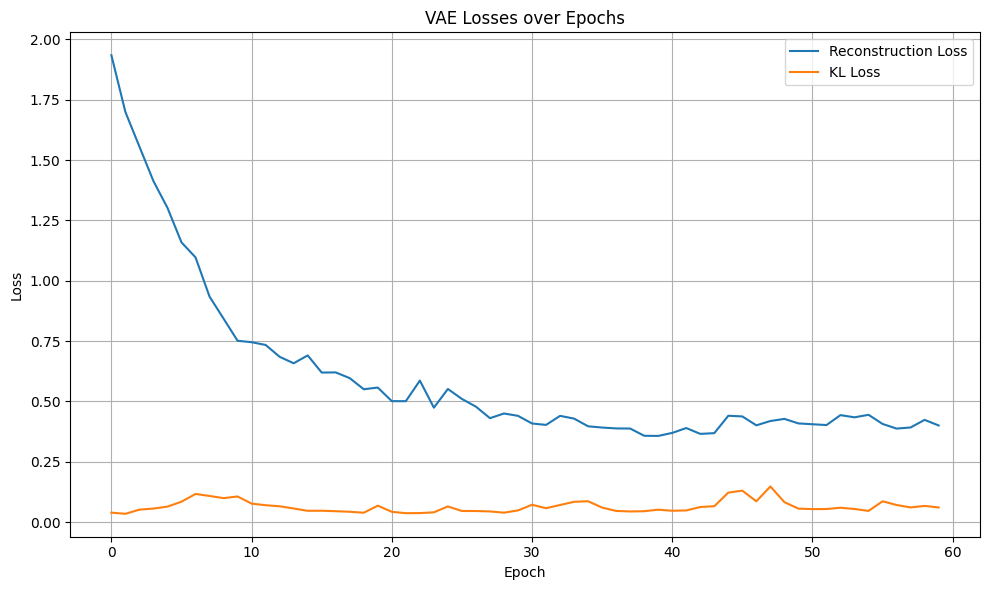

In [465]:
plt.figure(figsize=(10, 6))


plt.plot(reconstruction_history, label='Reconstruction Loss')
plt.plot(kl_history, label='KL Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Losses over Epochs")
plt.legend()


plt.grid(True)
plt.tight_layout()
#plt.ylim(0, 1)
plt.show()


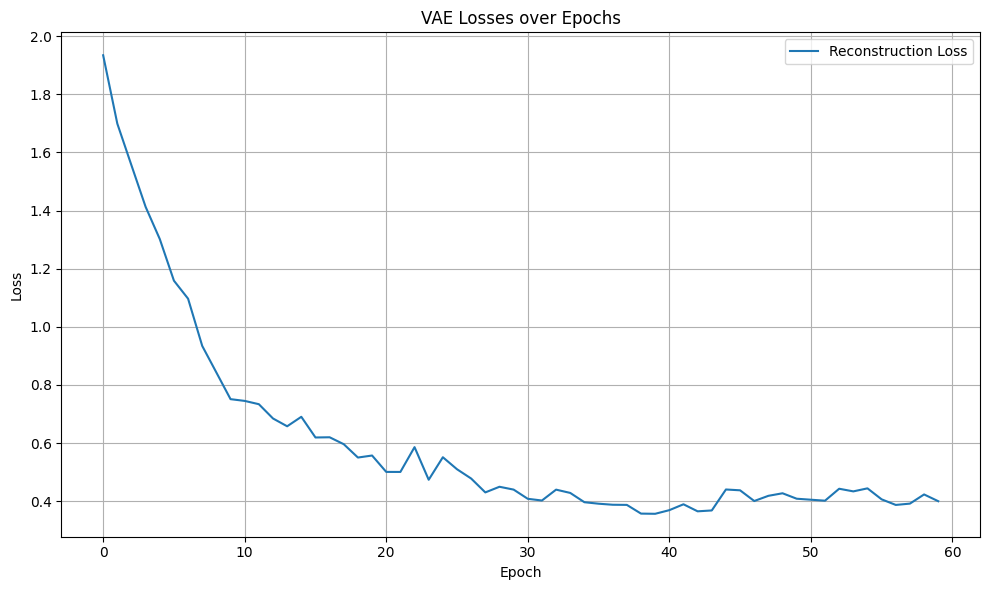

In [398]:
plt.figure(figsize=(10, 6))

#plt.plot(loss_history, label='Total Loss')
plt.plot(reconstruction_history, label='Reconstruction Loss')
#plt.plot(kl_history, label='KL Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Losses over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(0, 1)
plt.show()

# Test

we pick time t1 = 60 and sample $z_{t_{1}}$ from $P_{b}(z_{t_{1}}|b_{t1})$.

/tmp/ipython-input-571229255.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)


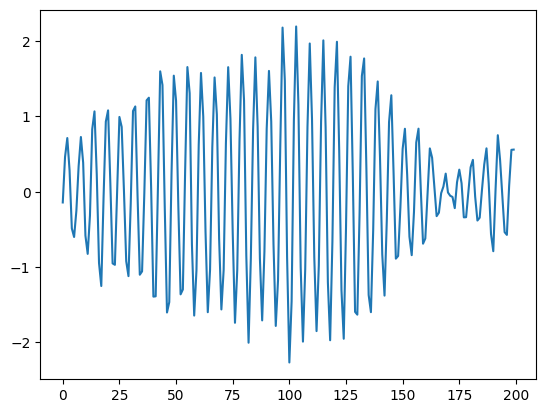

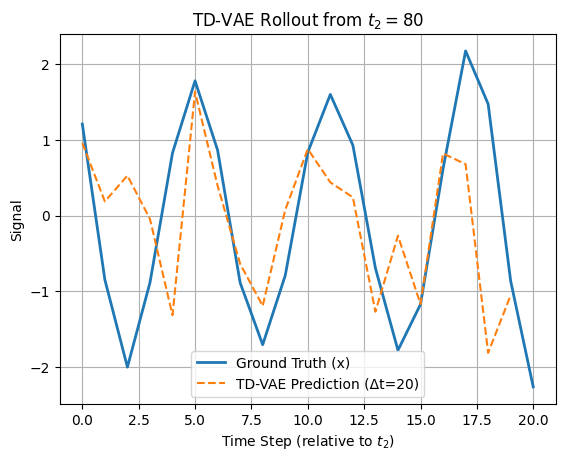

In [420]:
def tdvae_rollout(x_test,model = vae, t1=60, jump = 20, n_steps=20):


    recon = []
    #we encode the test signal and get bt and the encoder zt
    #encoder
    bt = vae.beliefs(X_test)
    mu2, logvar2 = vae.belief_layer2(bt[:, t1, :])  # shape: [batch, latent_dim_2]
    zt2_layer2 = sample_gaussian(mu2, logvar2) #term 1

    mu1, logvar1 = vae.belief_layer1(torch.cat([bt[:, t1, :], zt2_layer2], dim=-1))
    zt2_layer1 = sample_gaussian(mu1, logvar1) #term 2

    zt1 = torch.cat([zt2_layer1, zt2_layer2], dim =-1) #term3


    #for each skip interval in Δt ∈ {20,100} we need to sample zt2 using the transition


    B , L = zt1.shape

    delta = 1 #time step


    #jump ahead to t1+dt(60+20, 60+100)# then move by delta(1) steps eahc time for n_steps(20)

    dt = torch.full((B,1), float(jump), device=zt1.device) # shape [B,1]
    mu_trans_layer2 , logvar_trans_layer2 = vae.transition_layer2(torch.cat([zt1,dt], dim = -1)) #term 9
    # since in training we didnt sample from transition, we have to seperately sample but it doesnt make a theoretcial difference
    zt2_layer2 = sample_gaussian(mu_trans_layer2, logvar_trans_layer2)
    mu_trans_layer1 , logvar_trans_layer1 = vae.transition_layer1(torch.cat([zt1,zt2_layer2, dt], dim = -1)) #term 10
    zt2_layer1 = sample_gaussian(mu_trans_layer1, logvar_trans_layer1)

    zt2 = torch.cat([zt2_layer1, zt2_layer2], dim=-1)
    xt1_jump = (zt2_layer1[:, :1]) #x60 + 20 = x80
    recon.append(xt1_jump)
    zt1 = zt2
    #now rollout. predicting n_steps(20) steps after the jump
    for i in range(1, n_steps):
      dt = torch.full((B,1), float(1), device=zt1.device) # shape [B,1]
      mu_trans_layer2 , logvar_trans_layer2 = vae.transition_layer2(torch.cat([zt1,dt], dim = -1)) #term 9
      # since in training we didnt sample from transition, we have to seperately sample but it doesnt make a theoretcial difference
      zt2_layer2 = sample_gaussian(mu_trans_layer2, logvar_trans_layer2)
      mu_trans_layer1 , logvar_trans_layer1 = vae.transition_layer1(torch.cat([zt1,zt2_layer2, dt], dim = -1)) #term 10
      zt2_layer1 = sample_gaussian(mu_trans_layer1, logvar_trans_layer1)

      zt2 = torch.cat([zt2_layer1, zt2_layer2], dim=-1)
      xt1_rollout = (zt2_layer1[:, :1]) #x60 + 20 = x80
      recon.append(xt1_rollout)
      zt1 = zt2

    return recon

X_test  = generate_harmonic_oscillator_data(1, noise_level=0.1)
X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)
x_pred_20 = tdvae_rollout(X_test_tensor, jump =20)
x_pred_100 = tdvae_rollout(X_test_tensor, jump = 100)

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,80:101, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_20, label='TD-VAE Prediction (Δt=20)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 80$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()







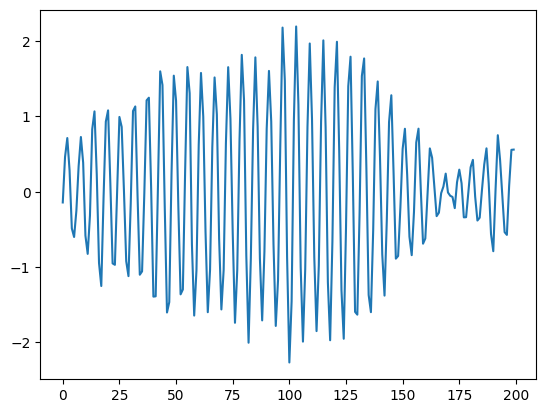

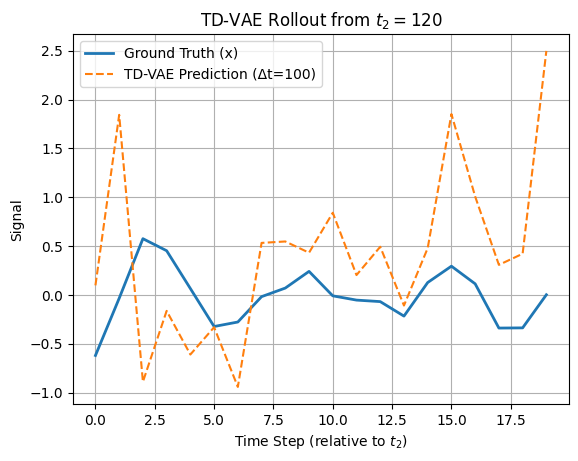

In [429]:
# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,160:180, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_100, dim=0)  # shape: [n_steps+1, 1]
recon_np_100 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_100, label='TD-VAE Prediction (Δt=100)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 120$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

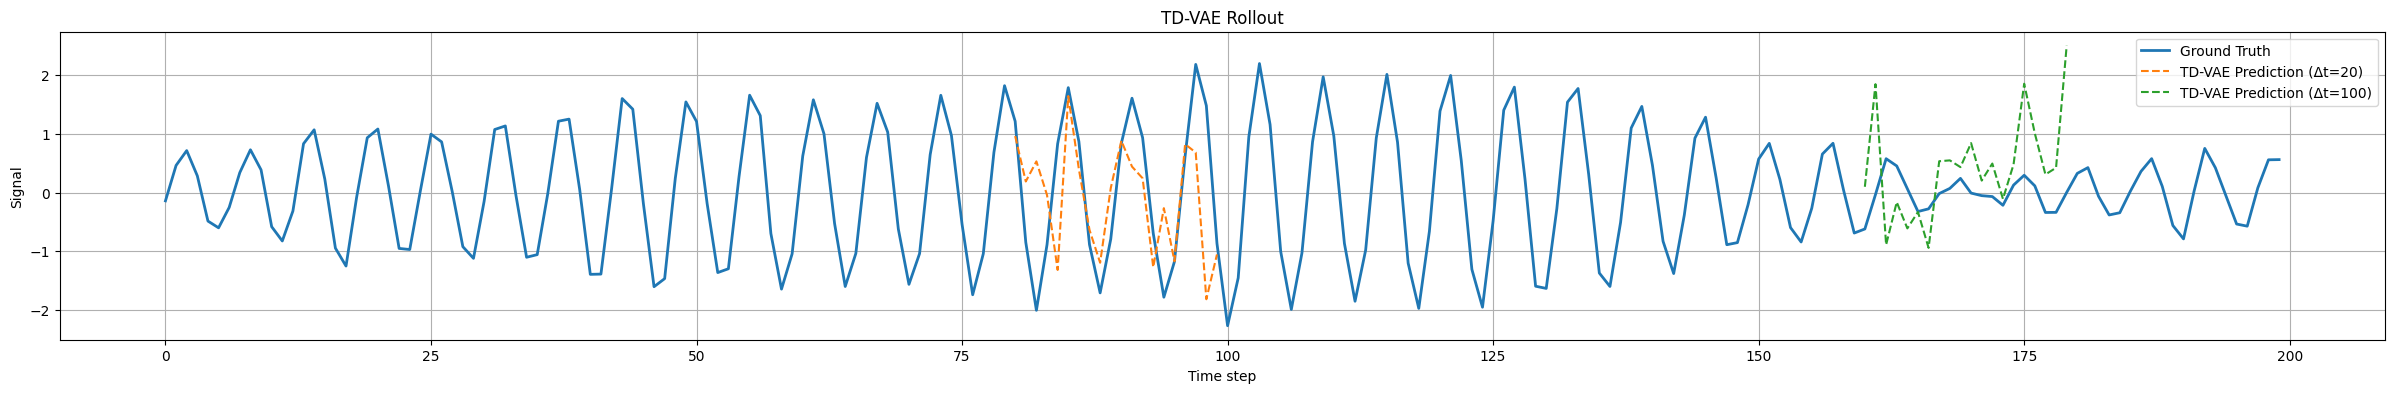

In [430]:

T = X_test.shape[1]
pred_full_20 = np.full(T, np.nan)
pred_full_100 = np.full(T,np.nan)

t2 = 80
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()
pred_full_20[t2 : t2 + len(recon_np_20)] = recon_np_20
t2 = 160
pred_full_100[t2 : t2 + len(recon_np_100)] = recon_np_100

plt.figure(figsize=(30,4))
plt.plot(np.arange(T), X_test[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(np.arange(T), pred_full_20, '--', label='TD-VAE Prediction (Δt=20)')
plt.plot(np.arange(T), pred_full_100, '--', label='TD-VAE Prediction (Δt=100)')
plt.title("TD-VAE Rollout")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.grid(True)
plt.legend()
plt.show()




## Some predictions

/tmp/ipython-input-109318986.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)


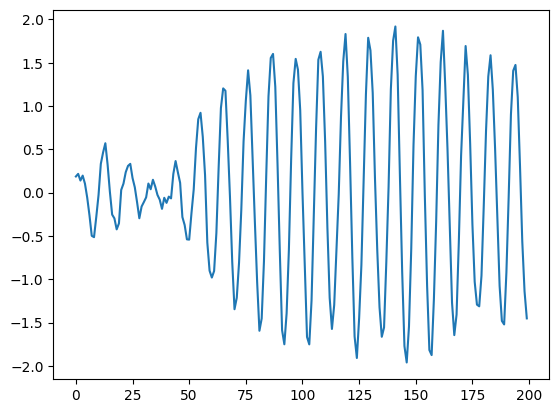

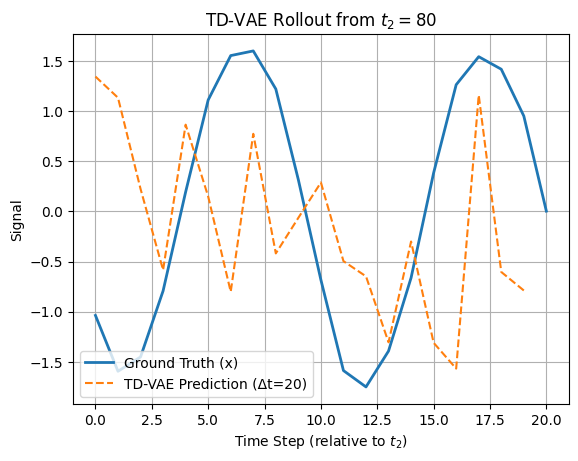

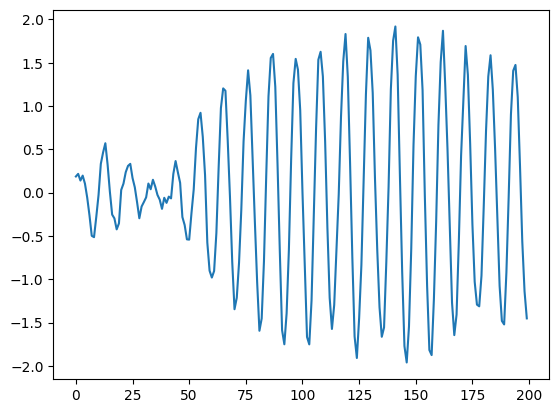

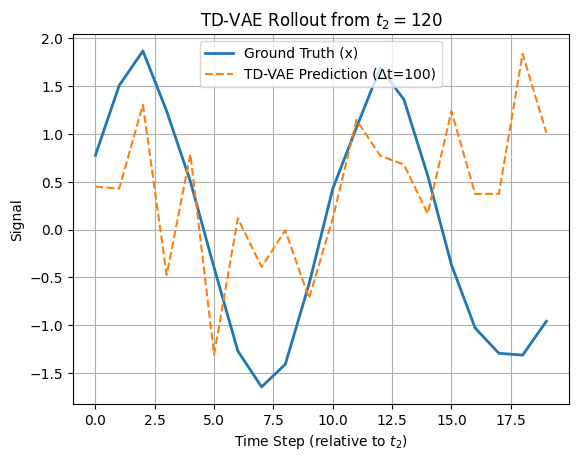

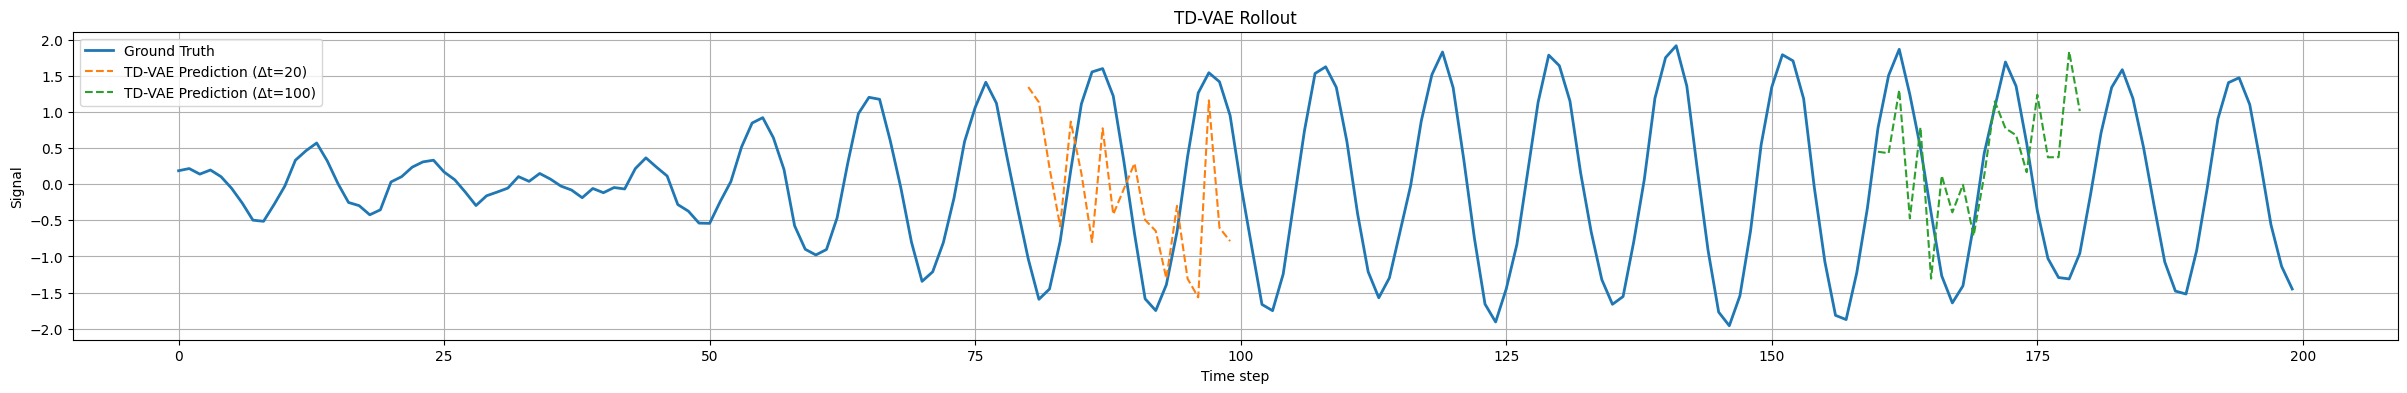

In [448]:

X_test  = generate_harmonic_oscillator_data(1, noise_level=0.1)
X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)
x_pred_20 = tdvae_rollout(X_test_tensor, jump =20)
x_pred_100 = tdvae_rollout(X_test_tensor, jump = 100)

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,80:101, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_20, label='TD-VAE Prediction (Δt=20)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 80$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,160:180, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_100, dim=0)  # shape: [n_steps+1, 1]
recon_np_100 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_100, label='TD-VAE Prediction (Δt=100)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 120$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()



T = X_test.shape[1]
pred_full_20 = np.full(T, np.nan)
pred_full_100 = np.full(T,np.nan)

t2 = 80
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()
pred_full_20[t2 : t2 + len(recon_np_20)] = recon_np_20
t2 = 160
pred_full_100[t2 : t2 + len(recon_np_100)] = recon_np_100

plt.figure(figsize=(30,4))
plt.plot(np.arange(T), X_test[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(np.arange(T), pred_full_20, '--', label='TD-VAE Prediction (Δt=20)')
plt.plot(np.arange(T), pred_full_100, '--', label='TD-VAE Prediction (Δt=100)')
plt.title("TD-VAE Rollout")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipython-input-500197810.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)


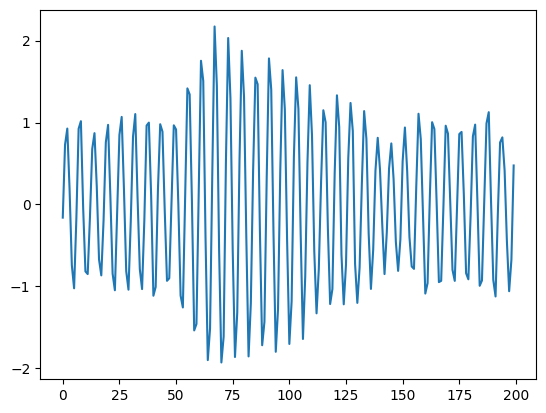

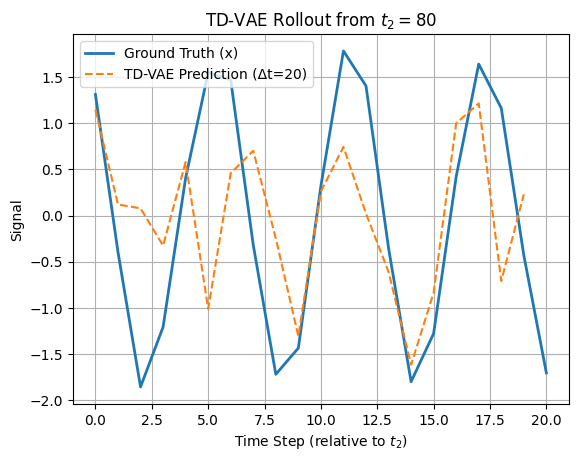

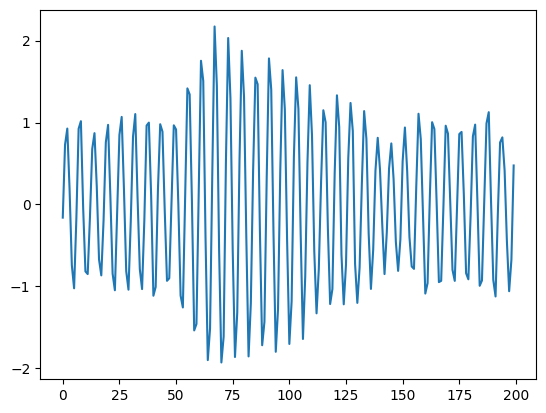

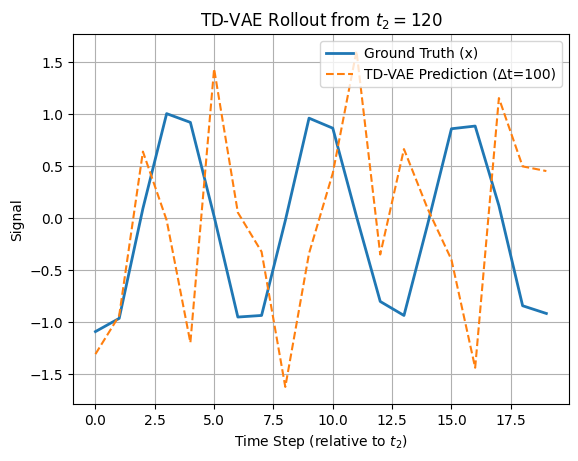

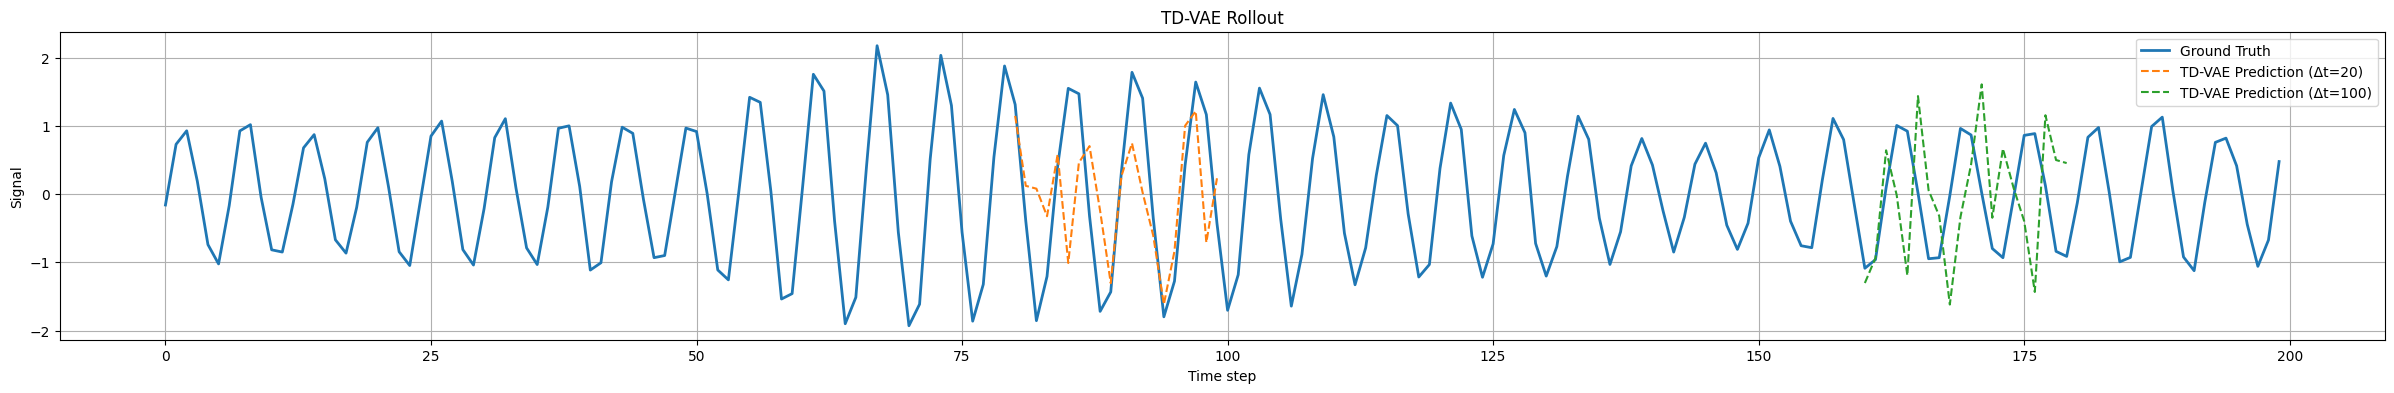

In [453]:

X_test  = generate_harmonic_oscillator_data(1, noise_level=0.1)
X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)
x_pred_20 = tdvae_rollout(X_test_tensor, jump =20)
x_pred_100 = tdvae_rollout(X_test_tensor, jump = 100)

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,80:101, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_20, label='TD-VAE Prediction (Δt=20)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 80$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,160:180, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_100, dim=0)  # shape: [n_steps+1, 1]
recon_np_100 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_100, label='TD-VAE Prediction (Δt=100)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 120$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()



T = X_test.shape[1]
pred_full_20 = np.full(T, np.nan)
pred_full_100 = np.full(T,np.nan)

t2 = 80
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()
pred_full_20[t2 : t2 + len(recon_np_20)] = recon_np_20
t2 = 160
pred_full_100[t2 : t2 + len(recon_np_100)] = recon_np_100

plt.figure(figsize=(30,4))
plt.plot(np.arange(T), X_test[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(np.arange(T), pred_full_20, '--', label='TD-VAE Prediction (Δt=20)')
plt.plot(np.arange(T), pred_full_100, '--', label='TD-VAE Prediction (Δt=100)')
plt.title("TD-VAE Rollout")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipython-input-500197810.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)


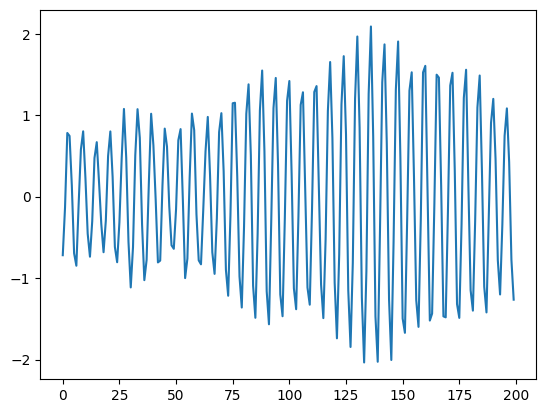

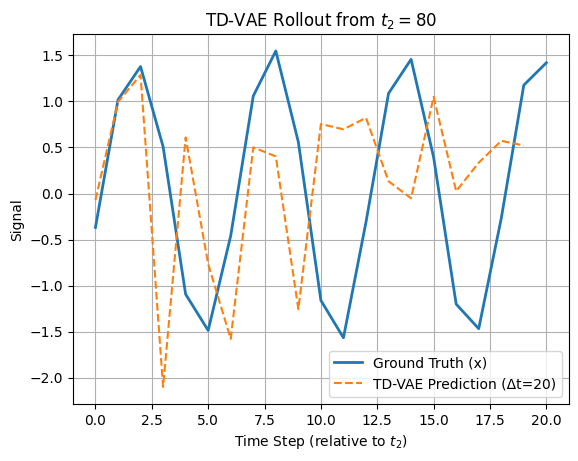

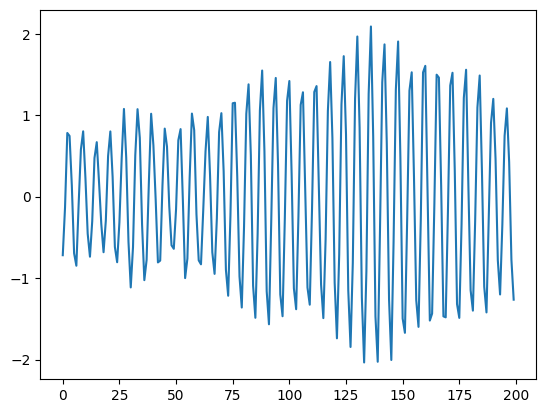

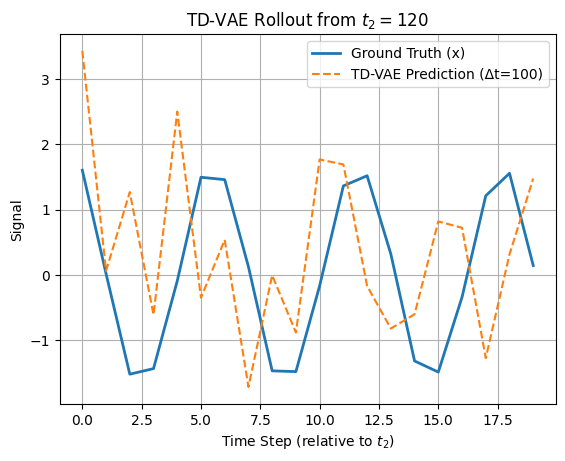

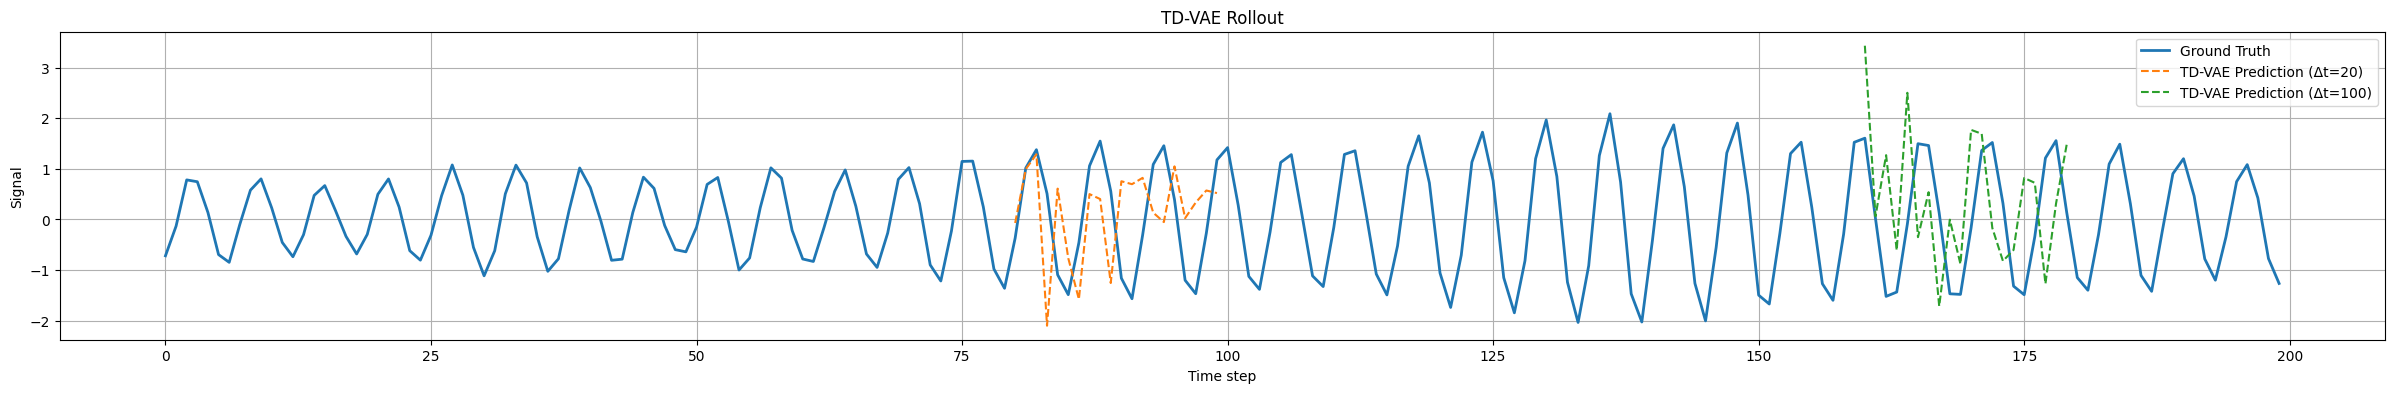

In [463]:

X_test  = generate_harmonic_oscillator_data(1, noise_level=0.1)
X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)
x_pred_20 = tdvae_rollout(X_test_tensor, jump =20)
x_pred_100 = tdvae_rollout(X_test_tensor, jump = 100)

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,80:101, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_20, label='TD-VAE Prediction (Δt=20)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 80$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,160:180, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_100, dim=0)  # shape: [n_steps+1, 1]
recon_np_100 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_100, label='TD-VAE Prediction (Δt=100)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 120$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()



T = X_test.shape[1]
pred_full_20 = np.full(T, np.nan)
pred_full_100 = np.full(T,np.nan)

t2 = 80
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()
pred_full_20[t2 : t2 + len(recon_np_20)] = recon_np_20
t2 = 160
pred_full_100[t2 : t2 + len(recon_np_100)] = recon_np_100

plt.figure(figsize=(30,4))
plt.plot(np.arange(T), X_test[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(np.arange(T), pred_full_20, '--', label='TD-VAE Prediction (Δt=20)')
plt.plot(np.arange(T), pred_full_100, '--', label='TD-VAE Prediction (Δt=100)')
plt.title("TD-VAE Rollout")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.grid(True)
plt.legend()
plt.show()

Ofcourse there are some bad results too

/tmp/ipython-input-500197810.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)


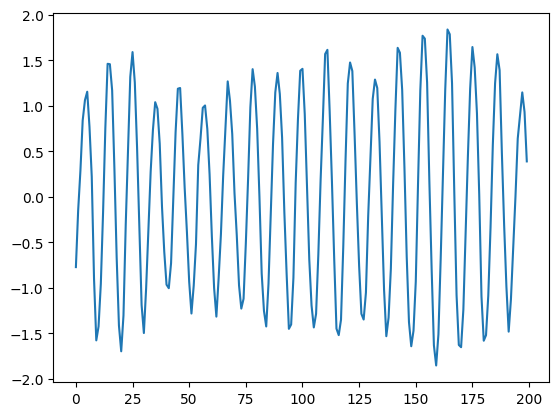

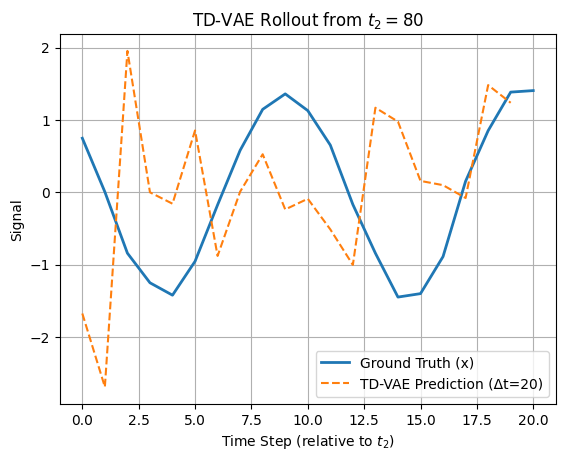

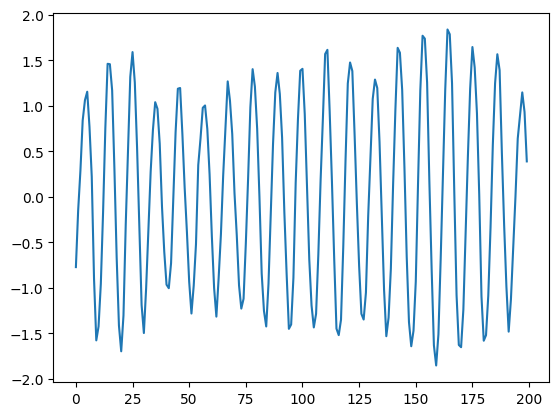

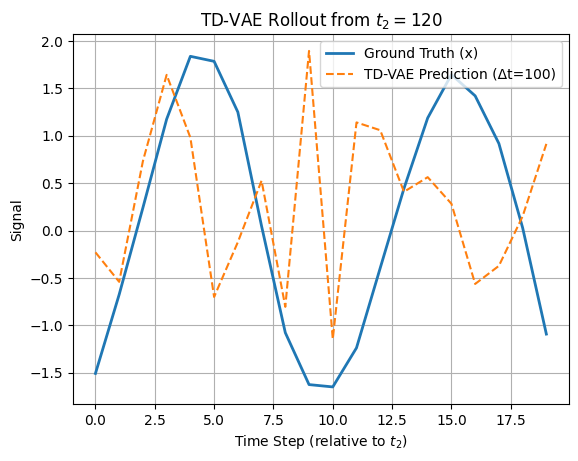

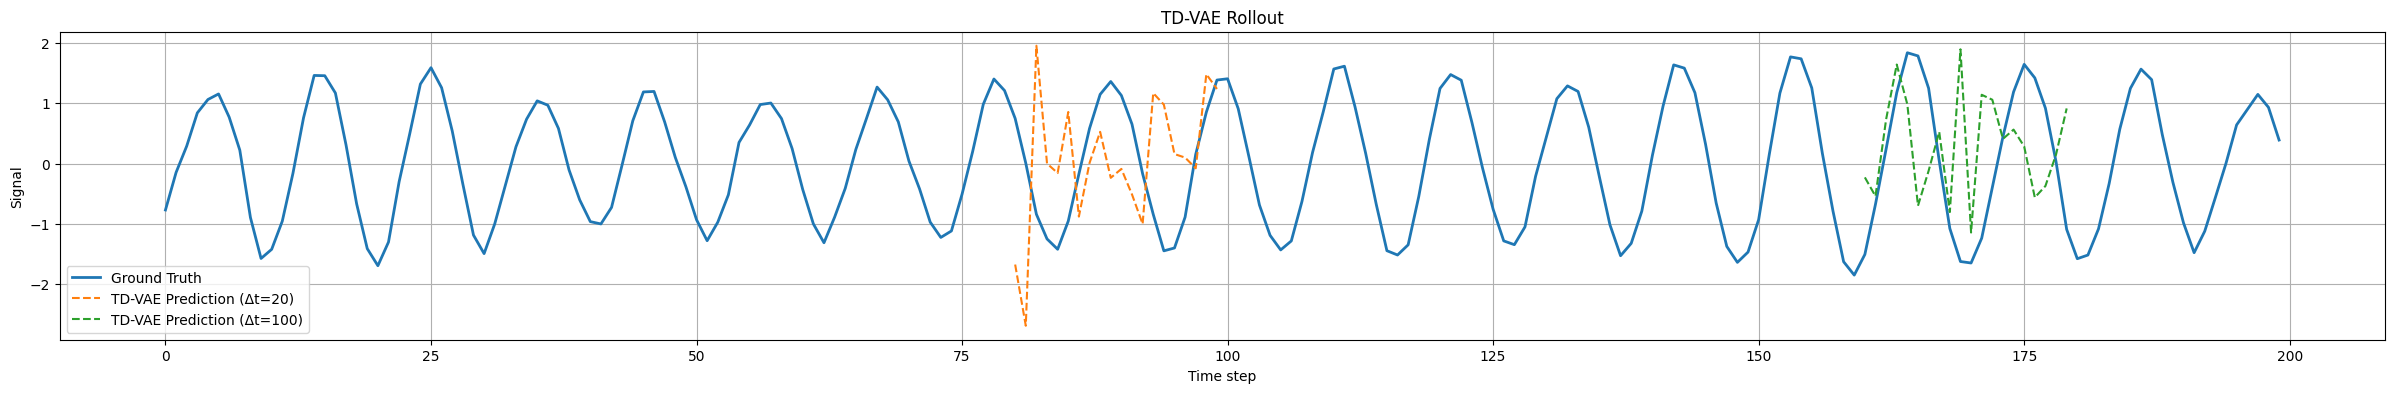

In [464]:

X_test  = generate_harmonic_oscillator_data(1, noise_level=0.1)
X_test_tensor= torch.tensor(X_test, dtype=torch.float32).to(device)
x_pred_20 = tdvae_rollout(X_test_tensor, jump =20)
x_pred_100 = tdvae_rollout(X_test_tensor, jump = 100)

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,80:101, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_20, label='TD-VAE Prediction (Δt=20)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 80$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

# Plot ground truth from t=80 to t=100
plt.plot(X_test[0])
plt.show()
plt.plot(X_test[0,160:180, 0], label='Ground Truth (x)', linewidth=2)


# Convert list of tensors to tensor → numpy
recon_tensor = torch.cat(x_pred_100, dim=0)  # shape: [n_steps+1, 1]
recon_np_100 = recon_tensor.squeeze().detach().cpu().numpy()

# Plot model predictions

plt.plot(recon_np_100, label='TD-VAE Prediction (Δt=100)', linestyle='--')


plt.title("TD-VAE Rollout from $t_2 = 120$")
plt.xlabel("Time Step (relative to $t_2$)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()



T = X_test.shape[1]
pred_full_20 = np.full(T, np.nan)
pred_full_100 = np.full(T,np.nan)

t2 = 80
recon_tensor = torch.cat(x_pred_20, dim=0)  # shape: [n_steps+1, 1]
recon_np_20 = recon_tensor.squeeze().detach().cpu().numpy()
pred_full_20[t2 : t2 + len(recon_np_20)] = recon_np_20
t2 = 160
pred_full_100[t2 : t2 + len(recon_np_100)] = recon_np_100

plt.figure(figsize=(30,4))
plt.plot(np.arange(T), X_test[0, :, 0], label='Ground Truth', linewidth=2)
plt.plot(np.arange(T), pred_full_20, '--', label='TD-VAE Prediction (Δt=20)')
plt.plot(np.arange(T), pred_full_100, '--', label='TD-VAE Prediction (Δt=100)')
plt.title("TD-VAE Rollout")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.grid(True)
plt.legend()
plt.show()